In [6]:
#Projet Mogpl M1 Informatique
#Dice Battle

#Yuhan WANG & Yufei LIU

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import sys
from gurobipy import *


#variable global N est le point cible et D est le nombre de dés qu'on peut lancer maximument chaque fois
#LP = ligne perdu signifie que si joueur1 a moins de cette ligne et joueur 2 a N-1 point alors joueur1 a perdu
N = 100
D = 10
LP = N - 6 * D

#Q1
class tab_p(object):
    
    def __init__(self, d):
        """
        entrée : le nombre de dés
        sortie : Q_tab et P_tab initialisé
        """
        self.D = d
        self.Q_tab=np.ones((self.D+1,6*self.D+1))*-1
        for a in range(0,6*self.D+1):
            self.Q_tab[0,a]=0
        for b in range(0,self.D+1):
            self.Q_tab[b,0]=0
        for i in range (2,7):
            #la propabilité d'obtenir 1 avec d dés
            self.Q_tab[1,i]=1/5
        
        self.P_tab=np.ones((self.D+1,6*self.D+1))*-2
        for c in range(0,self.D+1):
            self.P_tab[c,0]=0
            self.P_tab[c,1]=1-np.power(5/6,c)
        for d in range(0,6*self.D+1):
            self.P_tab[0,d]=0
            
            
    def Q(self,d,k):
        if d<=0:
            return 0
        if k<=0 | ((k>1) & (k<2*d)) | k>6*d :
            return 0
        else:
            if(self.Q_tab[d,k]!=-1):
                #print(d,k,Q_tab[d,k])
                return self.Q_tab[d,k]
            else:
                res = 0
                for j in range(2,7):
                    #print(d-1,k-j)
                    if(self.Q_tab[d-1,k-j]==-1):
                        self.Q_tab[d-1,k-j]=self.Q(d-1,k-j)
                    res += self.Q(d-1,k-j)
                return res/5
            
    def P(self,d,k):
        if(k==1):
            return self.P_tab[d,1]
        if self.P_tab[d,k]!=-2:
            return self.P_tab[d,k]
        else:
            self.P_tab[d,k]=(5/6)**d*self.Q(d,k)
            return self.P_tab[d,k]

    
    
global TAB_P
TAB_P = tab_p(D)

In [8]:
#Q2

def calcul_EP(d):
    return 4*d*(5/6)**d + 1 - (5/6)**d

print(calcul_EP(5))
print(calcul_EP(6))
#On doit choisir d*=6 car EP(6) est supérieur de EP(5)




8.63567386831276
8.702653463648836


In [9]:
class strategie_optimal(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        self.tab = np.ones((N,N))*100
        self.best_choice = np.zeros((N,N))
        global TAB_P
        if D>TAB_P.D:
            TAB_P = tab_p(D)
         
    def EG(self,i,j):
        if(i>=self.N):
            return 1
        elif(j>=self.N):
            return -1
        elif self.tab[i][j]<100:
            return self.tab[i][j]
        
        exps=[]
        for d1 in range(1,self.D+1):
            exp=0
            for e1 in range(1,6*d1+1):
                exp += TAB_P.P(d1,e1) * self.EG(j,i+e1)
            exps.append(-exp)
        self.tab[i][j]=max(exps)
        self.best_choice[i][j]=int(np.argmax(exps)+1)
        #self.best_choice[i][j]=int(np.argmax(exps))
        return self.tab[i][j]
    
    def choice_optimal(self,i,j):
        if self.best_choice[i][j]<1:
            t = self.EG(i,j)
        return self.best_choice[i][j]
    

In [10]:
#Q7
class strategie_aveugle(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        
    def choice_optimal(self,i,j):
        if self.D > 5:
            return 6
        return self.D
    
stra_opt1 = strategie_optimal(10,100)
stra_opt1 = strategie_optimal(10,100)
#def strategie_optimale(i,j):


In [11]:
#Q8
def get_random_score(d):
    res = 0
    for i in range(d):
        tmp = random.randint(1 , 6)
        if(tmp==1):
            return 1
        res += tmp
    return res


def game_ai(n,stra1,stra2,from_i, from_j):
    state=[from_i,from_j]
    while(state[1]<n)&(state[0]<n):
        #print("Score of player1: ",state[0],"\n Score of player2: ",state[1],"\n")
        d1 = int(stra1.choice_optimal(state[0],state[1]))
        p1 = get_random_score(d1)
        #temp = state[0]
        state[0] += p1
        #print("AI111 get ",p1, "score with ",d1," dice(s)!\n")
        if(state[0]>=n):
            return 1
        d2 = int(stra2.choice_optimal(state[1],state[0]))
        p2 = get_random_score(d2)
        state[1] += p2
        #print("AI222 get ",p2, "score with ",d2," dice(s)!\n")
        if(state[1]>=n):
            return -1
    """if state[0]>=n:
        return 1
    else:
        return -1"""

        

def test_D(D,N):
    n_test = 1000
    n_intervalle = 10
    ds = [ int(D*i/n_intervalle) for i in range(1,1+n_intervalle)]
    res = np.zeros((4,n_intervalle))
    #res = [aa,ao,oa,oo]
    for di in range(len(ds)):
        res_aa = 0
        res_ao = 0
        res_oa = 0
        res_oo = 0
        stra_opt = strategie_optimal(ds[di],N)
        stra_avg = strategie_aveugle(ds[di],N)
        for i in range(n_test):
            res_aa += game_ai(N,stra_avg,stra_avg,0,0)
            res_ao += game_ai(N,stra_avg,stra_opt,0,0)
            res_oa += game_ai(N,stra_opt,stra_avg,0,0)
            res_oo += game_ai(N,stra_opt,stra_opt,0,0)
            
        res[0][di] = res_aa / n_test
        res[1][di] = res_ao / n_test
        res[2][di] = res_oa / n_test
        res[3][di] = res_oo / n_test
        
    plt.plot(ds , res[0], c='r')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("variance de gain J1")
    plt.title("J1 aveugle & J2 aveugle")
    plt.show()
    
    plt.plot(ds , res[1], c='blue')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("variance de gain J1")
    plt.title("J1 aveugle & J2 optimal")
    plt.show()
    
    plt.plot(ds , res[2], c='y')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("variance de gain J1")
    plt.title("J1 optimal & J2 aveugle")
    plt.show()
    
    plt.plot(ds , res[3], c='black')
    plt.xlabel("nombre de dé possible")
    plt.ylabel("variance de gain J1")
    plt.title("J1 optimal & J2 optimal")
    plt.show()
    return res
    

    
def test_N(D,N):
    n_test = 1000
    n_intervalle = 10
    ns = [ int(N*i/n_intervalle) for i in range(1,1+n_intervalle)]
    res = np.zeros((4,n_intervalle))
    #stra_opt = strategie_optimal(D,N)
    #res = [aa,ao,oa,oo]
    stra_opt = strategie_optimal(D,N)
    stra_avg = strategie_aveugle(D,N)
    for ni in range(len(ns)):
        res_aa = 0
        res_ao = 0
        res_oa = 0
        res_oo = 0
        for i in range(n_test):
            res_aa += game_ai(N,stra_avg,stra_avg,N-ns[ni],N-ns[ni])
            res_ao += game_ai(N,stra_avg,stra_opt,N-ns[ni],N-ns[ni])
            res_oa += game_ai(N,stra_opt,stra_avg,N-ns[ni],N-ns[ni])
            res_oo += game_ai(N,stra_opt,stra_opt,N-ns[ni],N-ns[ni])
            
        res[0][ni] = res_aa / n_test
        res[1][ni] = res_ao / n_test
        res[2][ni] = res_oa / n_test
        res[3][ni] = res_oo / n_test
        
    plt.plot(ns , res[0], c='r')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("variance de gain J1")
    plt.title("J1 aveugle & J2 aveugle")
    plt.show()
    
    plt.plot(ns , res[1], c='blue')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("variance de gain J1")
    plt.title("J1 aveugle & J2 optimal")
    plt.show()
    
    plt.plot(ns , res[2], c='y')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("variance de gain J1")
    plt.title("J1 optimal & J2 aveugle")
    plt.show()
    
    plt.plot(ns , res[3], c='black')
    plt.xlabel("ligne N pour gagner")
    plt.ylabel("variance de gain J1")
    plt.title("J1 optimal & J2 optimal")
    plt.show()
    return res

In [12]:
stra_opt = strategie_optimal(10,100)

In [13]:
stra_opt.choice_optimal(0,0)

6.0

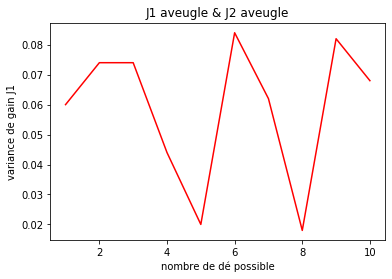

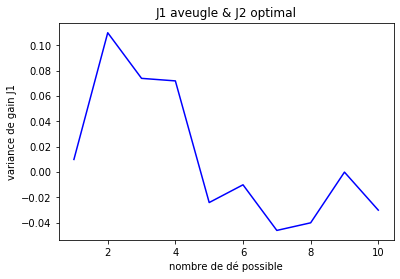

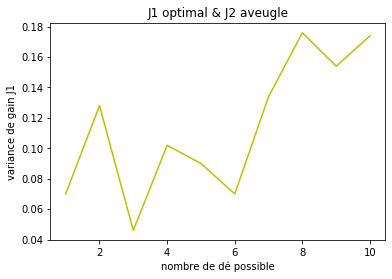

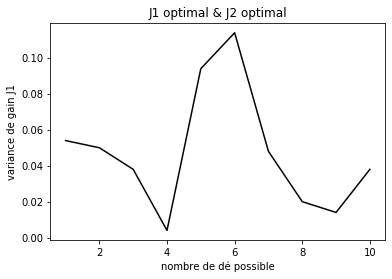

array([[ 0.06 ,  0.074,  0.074,  0.044,  0.02 ,  0.084,  0.062,  0.018,
         0.082,  0.068],
       [ 0.01 ,  0.11 ,  0.074,  0.072, -0.024, -0.01 , -0.046, -0.04 ,
         0.   , -0.03 ],
       [ 0.07 ,  0.128,  0.046,  0.102,  0.09 ,  0.07 ,  0.134,  0.176,
         0.154,  0.174],
       [ 0.054,  0.05 ,  0.038,  0.004,  0.094,  0.114,  0.048,  0.02 ,
         0.014,  0.038]])

In [9]:
test_D(10,200)

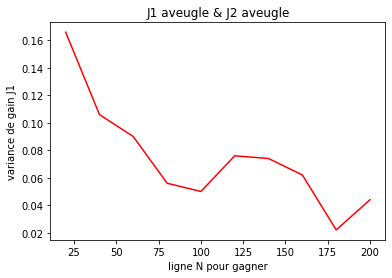

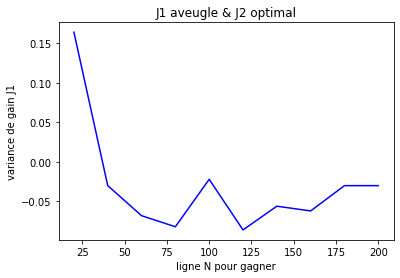

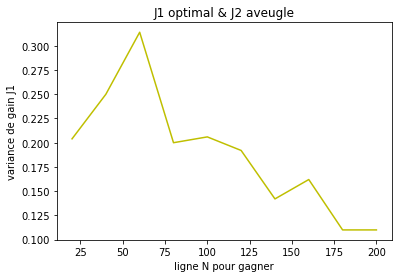

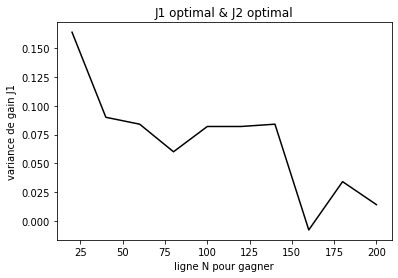

array([[ 0.166,  0.106,  0.09 ,  0.056,  0.05 ,  0.076,  0.074,  0.062,
         0.022,  0.044],
       [ 0.164, -0.03 , -0.068, -0.082, -0.022, -0.086, -0.056, -0.062,
        -0.03 , -0.03 ],
       [ 0.204,  0.25 ,  0.314,  0.2  ,  0.206,  0.192,  0.142,  0.162,
         0.11 ,  0.11 ],
       [ 0.164,  0.09 ,  0.084,  0.06 ,  0.082,  0.082,  0.084, -0.008,
         0.034,  0.014]])

In [10]:
test_N(10,200)

In [14]:
#print(stra_opt1.EG(95,95))
[stra_opt1.EG(i,99) for i in range(0,100)]
print(stra_opt1.EG(0,0))

0.06871904732303523


In [15]:
#Q9
class game(object):
    def __init__(self, D, N):
        self.N = N
        self.D = D
        self.tab = np.ones((N,N))*100
        
    
    def start_conter_ai(self,strategie):
        state=[0,0]
        tour = 0
        while(state[1]<self.N)&(state[0]<self.N):
            tour += 1
            print("*****************************************\n")
            print("Tour:",tour, "\n Score of player1: ",state[0],"\n Score of player2: ",state[1],"\n Score of target: ",self.N )
            print("You can make a choice between 1 and ",self.D," for this round:")
            d1 = int(input())
            p1 = get_random_score(d1)
            print("You get ",p1, "score with ",d1, " dice(s)!\n")
            state[0]+=p1
            if(state[0]>=self.N):
                break
            d2 = int(strategie.choice_optimal(state[1],state[0]))
            p2 = get_random_score(d2)
            print("AI get ",p2, "score with ",d2," dice(s)!\n")
            state[1]+=p2
            print("\n\n\n\n\n\n")
            
        if state[0]>=self.N:
            print("You win")
        else:
            print("•••You lose•••")
            
    def start(self):
        pygame.init()
        screen = pygame.display.set_mode((640,480),0,32)
        pygame.display.set_caption("Dice Battle")
        dice = pygame.image.load("img/dice_0.jpg")
        print(dice)
        dice_x, dice_y = 0, 0  
        h_direction = 1  
        speed = 10
        width = 844
        while 1:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
            
            screen.blit(dice, (dice_x, dice_y))
            dice_x += speed * h_direction
            if dice_x > width:
                h_direction = -h_direction
            elif dice_x < 0:
                h_direction = -h_direction
            pygame.display.update()
            

        



In [44]:
game1 = game(10,100)
game1.start_conter_ai(stra_opt1)

*****************************************

Tour: 1 
 Score of player1:  0 
 Score of player2:  0 
 Score of target:  100
You can make a choice between 1 and  10  for this round:
6
You get  27 score with  6  dice(s)!

AI get  1 score with  6  dice(s)!








*****************************************

Tour: 2 
 Score of player1:  27 
 Score of player2:  1 
 Score of target:  100
You can make a choice between 1 and  10  for this round:
6
You get  23 score with  6  dice(s)!

AI get  1 score with  6  dice(s)!








*****************************************

Tour: 3 
 Score of player1:  50 
 Score of player2:  2 
 Score of target:  100
You can make a choice between 1 and  10  for this round:
6
You get  23 score with  6  dice(s)!

AI get  25 score with  7  dice(s)!








*****************************************

Tour: 4 
 Score of player1:  73 
 Score of player2:  27 
 Score of target:  100
You can make a choice between 1 and  10  for this round:
6
You get  24 score with  6  dice(s)!

A

In [18]:
game2 = game(10,100)
#game2.start()


In [250]:
#Q10
D1=3
#TAB_P1 = tab_p(D1).P_tab
EG1=np.ones((D1,D1))*-1

def calculer_EG1(D,tab):
    for i in range(1,D1+1):
        for j in range(1,D1+1):
            gain=0
            perd=0
            moin=0
            plus=0
            for a in range(1,6*i+1):
                for b in range(1,6*j+1):
                    if(a>b):
                        plus+=1
                        gain+=tab.P(i,a)*tab.P(j,b)
                    else:
                        if(a<b):
                            moin+=1
                            perd+=tab.P(i,a)*tab.P(j,b)
            if(i==j):
                EG1[i-1,j-1]=0
            else:
                EG1[i-1,j-1]=gain-perd
    return EG1


In [251]:
print(2/3)

0.6666666666666666


In [258]:
#Q13
def proglineaire(D):
    
    nb_prob = D.shape[0]
    
    q = []
    
    #matrice de contrainte
    m = Model("s0")
    alpha = m.addVar(vtype=GRB.CONTINUOUS, name="alpha") 
    m.setObjective(alpha,GRB.MINIMIZE)
    
    #le somme des probabilitées egalent à 1
    for i in range(nb_prob):
        q.append(m.addVar(vtype=GRB.CONTINUOUS,lb=0,ub=1,name="p%d"%(i+1)))
        #res=LinExpr()

    
    for i in range(nb_prob):
        expr = LinExpr()
        for j in range(nb_prob): 
            #expr+=D[i,j]*q[j]*(-1) #5:0.61 10:1
            #expr+=D[i,j]*q[j] #5:0.771 10:normal
            #print("D",D[j,i],j)
            expr+=D[j,i]*q[j]*(-1)   
        m.addConstr(alpha>=expr)
        
    expr1 = LinExpr()
    for i in range(nb_prob):
        expr1+=q[i]
    m.addConstr(expr1==1)
    
    
        
    m.optimize()
    print("solution optimale:",q) 

In [259]:
temp=calculer_EG1(D1,TAB_P)
print(proglineaire(temp))

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 4 rows, 4 columns and 12 nonzeros
Model fingerprint: 0x58ffbac4
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 3 rows, 4 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.988169e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
solution optimale: [<gurobi.Var p1 (value 0.0)>, <gurobi.Var p2 (value 0.0)>, <gurobi.Var p3 (value 1.0)>]
None


In [254]:
print(temp)

[[ 0.         -0.375      -0.22685185]
 [ 0.375       0.         -0.19881687]
 [ 0.22685185  0.19881687  0.        ]]


In [232]:
print(np.sum(temp,axis=1))

[-0.01505404  0.42195547  0.46896963  0.29043949 -0.01149704 -0.37789167
 -0.77692184]


In [54]:
nb_prob=5
q=np.ones(nb_prob).reshape((nb_prob,1))

In [57]:
for i in range(nb_prob):
    print(temp[i,:]*q[:,0])

[ 0.         -0.375      -0.22685185 -0.05079733  0.09655778]
[ 0.375       0.         -0.19881687 -0.11640518  0.0136424 ]
[ 0.22685185  0.19881687  0.         -0.10027292 -0.04524844]
[ 0.05079733  0.11640518  0.10027292  0.         -0.04477462]
[-0.09655778 -0.0136424   0.04524844  0.04477462  0.        ]
